   season mechanism  elim_weeks  consistency_rate  avg_margin
0      30   bottom2           8               0.5    0.044114


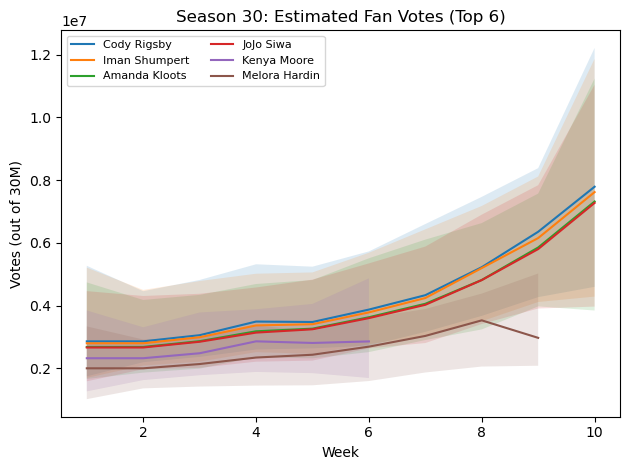

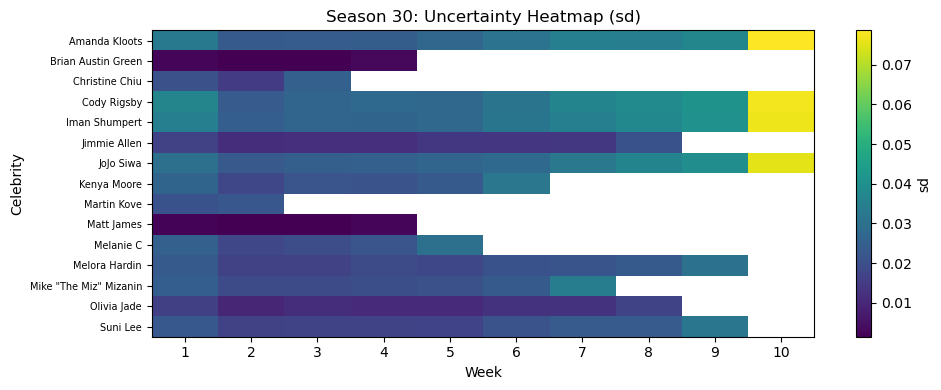

In [14]:
import re
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from scipy.optimize import minimize
import matplotlib.pyplot as plt

TOTAL_VOTES = 30_000_000

# -----------------------
# A) 赛季机制分组
# -----------------------
def season_group(season: int) -> str:
    # 你定义的三类
    if 1 <= season <= 2:
        return "rank"      # S1-2: judge rank + fan rank
    if 3 <= season <= 27:
        return "percent"   # S3-27: judge% + fan%
    return "bottom2"       # S28-34: bottom-2 by combined, judges eliminate one

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def softplus(x):
    return np.log1p(np.exp(x))

# -----------------------
# B) 数据整理（支持到 34）
# -----------------------
def load_and_make_long(csv_path: str, max_season: int = 34) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df = df[df["season"] <= max_season].copy()

    week_cols = [c for c in df.columns if c.startswith("week") and c.endswith("_score")]
    long = df.melt(
        id_vars=[
            "celebrity_name", "ballroom_partner", "celebrity_industry",
            "celebrity_homestate", "celebrity_homecountry/region",
            "celebrity_age_during_season", "season", "results", "placement"
        ],
        value_vars=week_cols,
        var_name="wk_j", value_name="score"
    )
    long["week"] = long["wk_j"].str.extract(r"week(\d+)_").astype(int)
    long["judge"] = long["wk_j"].str.extract(r"_judge(\d+)_").astype(int)
    long["score"] = pd.to_numeric(long["score"], errors="coerce")
    long = long.drop(columns=["wk_j"])

    wk_tot = (
        long.groupby(["season", "celebrity_name", "week"], as_index=False)["score"]
        .sum(min_count=1)
        .rename(columns={"score": "judge_total"})
    )
    wk_tot["active"] = wk_tot["judge_total"].fillna(0.0) > 0.0

        # judge_percent（S3+ 用）：不用 apply，避免丢 season/week 列
    # 只在 active 的人里做归一化
    wk_tot["judge_total_active"] = wk_tot["judge_total"].where(wk_tot["active"], 0.0)
    denom = wk_tot.groupby(["season", "week"])["judge_total_active"].transform("sum")

    wk_tot["judge_percent"] = np.nan
    m = wk_tot["active"] & (denom > 0)
    wk_tot.loc[m, "judge_percent"] = wk_tot.loc[m, "judge_total"] / denom.loc[m]

    wk_tot = wk_tot.drop(columns=["judge_total_active"])


    # 解析淘汰周
    def parse_elim_week(res: str) -> Optional[int]:
        m = re.match(r"Eliminated Week (\d+)", str(res))
        return int(m.group(1)) if m else None

    base = df[["season", "celebrity_name", "results", "placement"]].copy()
    base["elim_week"] = base["results"].apply(parse_elim_week)
    base["withdrew"] = base["results"].eq("Withdrew")

    last_active = (
        wk_tot[wk_tot["active"]]
        .groupby(["season", "celebrity_name"], as_index=False)["week"]
        .max()
        .rename(columns={"week": "last_week_active"})
    )
    base = base.merge(last_active, on=["season", "celebrity_name"], how="left")
    base["withdrew_week"] = np.where(base["withdrew"], base["last_week_active"], np.nan)

    wk = wk_tot.merge(
        base[["season", "celebrity_name", "elim_week", "withdrew_week"]],
        on=["season", "celebrity_name"], how="left"
    )

    season_max_week = wk[wk["active"]].groupby("season")["week"].max().to_dict()
    wk["season_max_week"] = wk["season"].map(season_max_week)
    return wk

# -----------------------
# C) 事件结构（加入 judge_total 和 judge_rank，方便 S1-2）
# -----------------------
@dataclass
class WeekEvent:
    season: int
    week: int
    active_names: List[str]
    eliminated_names: List[str]
    withdrew_names: List[str]
    is_no_elim_week: bool
    k_elim: int
    judge_total: np.ndarray       # aligned to active_names
    judge_percent: np.ndarray     # aligned to active_names (may be nan for S1-2 but OK)
    judge_rank: np.ndarray        # aligned to active_names (best=1)

def build_week_events(wk: pd.DataFrame) -> Dict[Tuple[int, int], WeekEvent]:
    events = {}
    for (s, t), g in wk.groupby(["season", "week"]):
        season_max = g["season_max_week"].iloc[0]
        if pd.isna(season_max) or t > int(season_max):
            continue

        active_g = g[g["active"]].copy()
        active_names = active_g["celebrity_name"].tolist()

        JT = active_g["judge_total"].to_numpy()
        JP = active_g["judge_percent"].to_numpy()

        # judge rank: 分数高 = rank小（更好）
        # ties 用 average rank
        order = (-JT).argsort()
        ranks = np.empty_like(order, dtype=float)
        ranks[order] = np.arange(1, len(JT) + 1, dtype=float)
        # 简单 tie 处理（如果你想更严格可按 groupby tie 平均）
        JR = ranks

        eliminated = active_g[active_g["elim_week"].eq(t)]["celebrity_name"].tolist()
        withdrew = active_g[active_g["withdrew_week"].eq(t)]["celebrity_name"].tolist()
        k_elim = len(eliminated)
        is_no_elim = (k_elim == 0) and (len(withdrew) == 0)

        events[(s, t)] = WeekEvent(
            season=s, week=t, active_names=active_names,
            eliminated_names=eliminated, withdrew_names=withdrew,
            is_no_elim_week=is_no_elim, k_elim=k_elim,
            judge_total=JT, judge_percent=JP, judge_rank=JR
        )
    return events

# -----------------------
# D) 共用：fan rank（S1-2 用）
# -----------------------
def fan_rank_from_share(v: np.ndarray) -> np.ndarray:
    # v 大 = rank小（更好）
    order = (-v).argsort()
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(v) + 1, dtype=float)
    return ranks

def expected_fan_rank_soft(v: np.ndarray, eta: float = 80.0) -> np.ndarray:
    # 可微近似：E[rank_i] = 1 + sum_j sigmoid(eta*(v_j - v_i))
    # v 越大，(v_j - v_i) 越负，sigmoid 越小 => rank 越接近 1
    dv = v[None, :] - v[:, None]  # v_i - v_j
    # 想要 sigmoid(v_j - v_i) = sigmoid(-dv)
    P = sigmoid(eta * (-dv))
    np.fill_diagonal(P, 0.0)
    return 1.0 + P.sum(axis=1)

# -----------------------
# E) 模型A：最大熵 + 平滑
#    - percent: 用硬不等式约束
#    - rank: 用软惩罚（因为 rank 不可微）
#    - bottom2: 用软惩罚（淘汰者在 bottom-2）
# -----------------------
def _soft_entropy(v: np.ndarray, eps: float = 1e-12) -> float:
    v = np.clip(v, eps, 1.0)
    return -np.sum(v * np.log(v))

def estimate_votes_modelA(events: Dict[Tuple[int, int], WeekEvent],
                          season: int,
                          smooth_lambda: float = 15.0,
                          entropy_lambda: float = 1.0,
                          mech_lambda: float = 30.0,
                          eta_rank: float = 80.0,
                          kappa: float = 60.0,
                          eps: float = 1e-6) -> pd.DataFrame:
    mech = season_group(season)
    season_events = [ev for (s, _), ev in events.items() if s == season]
    season_events = sorted(season_events, key=lambda e: e.week)

    out_rows = []
    v_prev = None

    for ev in season_events:
        names = ev.active_names
        n = len(names)

        if v_prev is None or len(v_prev) != n:
            x0 = np.ones(n) / n
        else:
            x0 = v_prev.copy()

        # --- 机制惩罚项 ---
        def mech_penalty(v):
            v = np.clip(v, eps, 1.0)
            v = v / v.sum()

            # 没有淘汰：不给机制惩罚（信息少，交给平滑/熵）
            if ev.k_elim <= 0:
                return 0.0

            elim_set = set(ev.eliminated_names)
            idx = {nm: i for i, nm in enumerate(names)}
            elim_idx = [idx[x] for x in ev.eliminated_names if x in idx]
            surv_idx = [i for i, nm in enumerate(names) if nm not in elim_set]

            if mech == "percent":
                # 硬约束在外面加（这里返回0）
                return 0.0

            if mech == "rank":
                # combined_rank = judge_rank + fan_rank（用 soft expected rank）
                fr = expected_fan_rank_soft(v, eta=eta_rank)
                cr = ev.judge_rank + fr  # 越大越差
                pen = 0.0
                # 期望：淘汰者 cr >= 任一幸存者 cr
                for ei in elim_idx:
                    for si in surv_idx:
                        d = cr[ei] - cr[si]  # should be >=0
                        pen += softplus(-kappa * d)
                return pen

            if mech == "bottom2":
                # 若该周是单淘汰：只要求淘汰者在 bottom-2（按 combined score 的“最差2个”）
                # 对多淘汰：退化为“最低k”的逻辑（更稳健）
                # percent型 combined：score = J% + v，越小越差
                J = ev.judge_percent
                c = J + v

                pen = 0.0
                if ev.k_elim == 1 and len(elim_idx) == 1:
                    ei = elim_idx[0]
                    # 期望 bad-rank（1=最差）: 1 + sum_j sigmoid(kappa*(c_e - c_j))
                    # 若 c_e 很小（很差），c_e - c_j 多为负，sigmoid小，rank接近1
                    bad_rank = 1.0 + np.sum(sigmoid(kappa * (c[ei] - c[np.arange(n) != ei])))
                    # 惩罚：rank > 2
                    pen += softplus(kappa * (bad_rank - 2.0))
                else:
                    # 多淘汰：要求每个淘汰者都“不优于”幸存者（最低k近似）
                    for ei in elim_idx:
                        for si in surv_idx:
                            d = (c[si] - c[ei])  # should be >=0
                            pen += softplus(-kappa * d)
                return pen

            return 0.0

        # --- 目标函数 ---
        def obj(v):
            v = np.clip(v, eps, 1.0)
            v = v / v.sum()

            smooth = 0.0
            if v_prev is not None and len(v_prev) == n:
                smooth = np.sum((v - v_prev) ** 2)

            return (
                smooth_lambda * smooth
                - entropy_lambda * _soft_entropy(v)
                + mech_lambda * mech_penalty(v)
                + 1e-4 * np.sum(v ** 2)
            )

        cons = [{"type": "eq", "fun": lambda v: np.sum(v) - 1.0}]
        bounds = [(eps, 1.0) for _ in range(n)]

        # percent 机制：加硬约束（最低淘汰/最低k淘汰）
        if mech == "percent" and ev.k_elim > 0:
            J = ev.judge_percent.copy()
            elim_set = set(ev.eliminated_names)
            idx = {name: i for i, name in enumerate(names)}
            elim_idx = [idx[x] for x in ev.eliminated_names if x in idx]
            surv_idx = [i for i, nm in enumerate(names) if nm not in elim_set]
            for ei in elim_idx:
                for si in surv_idx:
                    cons.append({"type": "ineq", "fun": lambda v, ei=ei, si=si: (J[si] + v[si]) - (J[ei] + v[ei])})

        res = minimize(obj, x0, method="SLSQP", bounds=bounds, constraints=cons, options={"maxiter": 400})
        v_hat = np.clip(res.x, eps, 1.0)
        v_hat = v_hat / v_hat.sum()

        v_prev = v_hat.copy()

        for nm, vs in zip(names, v_hat):
            out_rows.append({
                "season": season, "week": ev.week, "celebrity_name": nm,
                "vote_share_A": vs, "votes_A": vs * TOTAL_VOTES,
                "opt_success_A": bool(res.success)
            })

    return pd.DataFrame(out_rows)

# -----------------------
# F) 模型B（贝叶斯思想）：MAP + 拉普拉斯近似抽样
#    - percent: pairwise “淘汰者更差”
#    - rank: pairwise “combined_rank 淘汰者更差”
#    - bottom2: 单淘汰周用 “淘汰者在 bottom2” 似然；多淘汰回退最低k pairwise
# -----------------------
def estimate_votes_modelB_map(events: Dict[Tuple[int, int], WeekEvent],
                              season: int,
                              sigma_rw: float = 0.35,
                              kappa: float = 45.0,
                              eta_rank: float = 80.0,
                              l2_beta: float = 1.0,
                              n_samples: int = 400,
                              seed: int = 7) -> Tuple[pd.DataFrame, pd.DataFrame]:
    mech = season_group(season)
    rng = np.random.default_rng(seed)

    season_events = [ev for (s, _), ev in events.items() if s == season]
    season_events = sorted(season_events, key=lambda e: e.week)

    keys = []
    for ev in season_events:
        for nm in ev.active_names:
            keys.append((ev.week, nm))
    keys = list(dict.fromkeys(keys))
    K = len(keys)
    key_to_i = {k: i for i, k in enumerate(keys)}

    def week_softmax(u_vec: np.ndarray, ev: WeekEvent) -> np.ndarray:
        idx = [key_to_i[(ev.week, nm)] for nm in ev.active_names]
        z = u_vec[idx]
        z = z - np.max(z)
        e = np.exp(z)
        return e / e.sum()

    def nlp(u_vec: np.ndarray) -> float:
        val = 0.0

        # RW 先验
        by_name = {}
        for (w, nm), ii in key_to_i.items():
            by_name.setdefault(nm, []).append((w, ii))
        for nm, arr in by_name.items():
            arr = sorted(arr, key=lambda x: x[0])
            for (w1, i1), (w2, i2) in zip(arr[:-1], arr[1:]):
                if w2 == w1 + 1:
                    diff = u_vec[i2] - u_vec[i1]
                    val += 0.5 * (diff / sigma_rw) ** 2

        # 机制似然
        for ev in season_events:
            if ev.k_elim <= 0:
                continue

            v = week_softmax(u_vec, ev)
            names = ev.active_names
            idx = {nm: i for i, nm in enumerate(names)}
            elim_names = [x for x in ev.eliminated_names if x in idx]
            elim_idx = [idx[x] for x in elim_names]
            elim_set = set(elim_idx)
            surv_idx = [i for i in range(len(names)) if i not in elim_set]

            if mech == "percent":
                J = ev.judge_percent
                c = J + v  # 越小越差
                for ei in elim_idx:
                    for si in surv_idx:
                        d = (c[si] - c[ei])  # should be >=0
                        val += -np.log(sigmoid(kappa * d) + 1e-12)

            elif mech == "rank":
                # combined_rank = judge_rank + expected_fan_rank_soft(v)
                fr = expected_fan_rank_soft(v, eta=eta_rank)
                cr = ev.judge_rank + fr  # 越大越差
                for ei in elim_idx:
                    for si in surv_idx:
                        d = (cr[ei] - cr[si])  # should be >=0
                        val += -np.log(sigmoid(kappa * d) + 1e-12)

            elif mech == "bottom2":
                J = ev.judge_percent
                c = J + v  # 越小越差
                if ev.k_elim == 1 and len(elim_idx) == 1:
                    ei = elim_idx[0]
                    # expected bad-rank（1=最差）
                    bad_rank = 1.0 + np.sum(sigmoid(kappa * (c[ei] - c[np.arange(len(c)) != ei])))
                    # P(elim in bottom2) ≈ sigmoid(kappa*(2 - bad_rank))
                    val += -np.log(sigmoid(kappa * (2.0 - bad_rank)) + 1e-12)
                else:
                    # 多淘汰：回退为最低k pairwise
                    for ei in elim_idx:
                        for si in surv_idx:
                            d = (c[si] - c[ei])
                            val += -np.log(sigmoid(kappa * d) + 1e-12)

        val += 0.5 * l2_beta * np.sum(u_vec ** 2) / max(K, 1)
        return val

    u0 = rng.normal(0, 0.1, size=K)
    res = minimize(nlp, u0, method="L-BFGS-B", options={"maxiter": 600})
    u_map = res.x

    # 拉普拉斯对角近似
    h = 1e-3
    f0 = nlp(u_map)
    Hdiag = np.zeros(K)
    for i in range(K):
        du = np.zeros(K); du[i] = h
        fp = nlp(u_map + du)
        fm = nlp(u_map - du)
        Hdiag[i] = max((fp - 2 * f0 + fm) / (h * h), 1e-6)
    cov_diag = 1.0 / Hdiag

    U = rng.normal(u_map, np.sqrt(cov_diag), size=(n_samples, K))

    map_rows = []
    sample_rows = []

    for ev in season_events:
        v_map = week_softmax(u_map, ev)
        for nm, vs in zip(ev.active_names, v_map):
            map_rows.append({
                "season": season, "week": ev.week, "celebrity_name": nm,
                "vote_share_B": vs, "votes_B": vs * TOTAL_VOTES,
                "opt_success_B": bool(res.success)
            })

        for sid in range(n_samples):
            v_s = week_softmax(U[sid], ev)
            for nm, vs in zip(ev.active_names, v_s):
                sample_rows.append({
                    "season": season, "week": ev.week, "celebrity_name": nm,
                    "sample_id": sid, "vote_share_sample": vs
                })

    return pd.DataFrame(map_rows), pd.DataFrame(sample_rows)

# -----------------------
# G) 集成
# -----------------------
def ensemble_votes(dfA: pd.DataFrame, dfB: pd.DataFrame, weight_B: float = 0.7) -> pd.DataFrame:
    df = dfA.merge(dfB, on=["season", "week", "celebrity_name"], how="inner")
    df["vote_share_ens"] = weight_B * df["vote_share_B"] + (1 - weight_B) * df["vote_share_A"]
    df["votes_ens"] = df["vote_share_ens"] * TOTAL_VOTES
    return df

# -----------------------
# H) 评估（按三类赛季自动切换）
# -----------------------
def evaluate_consistency(events: Dict[Tuple[int, int], WeekEvent],
                         votes_df: pd.DataFrame,
                         share_col: str = "vote_share_ens") -> pd.DataFrame:
    rows = []

    for season in sorted(votes_df["season"].unique()):
        mech = season_group(season)
        season_events = [ev for (s, _), ev in events.items() if s == season]
        season_events = sorted(season_events, key=lambda e: e.week)

        hits = 0
        denom = 0
        margins = []

        for ev in season_events:
            if ev.k_elim <= 0:
                continue

            sub = votes_df[(votes_df["season"] == season) & (votes_df["week"] == ev.week)]
            sub = sub.set_index("celebrity_name")

            names = ev.active_names
            v = np.array([float(sub.loc[nm, share_col]) if nm in sub.index else 0.0 for nm in names])

            elim = ev.eliminated_names
            if len(elim) == 0:
                continue

            denom += 1

            if mech == "percent":
                J = ev.judge_percent
                c = J + v  # 越小越差
                order = np.argsort(c)  # 最差在前
                k = ev.k_elim
                pred_bottom_k = {names[i] for i in order[:k]}
                actual = set(elim)
                hit = actual.issubset(pred_bottom_k)
                hits += int(hit)

                if len(order) > k:
                    thr = c[order[k-1]]
                    nxt = c[order[k]]
                    margins.append(nxt - thr)

            elif mech == "rank":
                fr = fan_rank_from_share(v)
                cr = ev.judge_rank + fr  # 越大越差
                order = np.argsort(-cr)  # 最大最差
                k = ev.k_elim
                pred_worst_k = {names[i] for i in order[:k]}
                actual = set(elim)
                hit = actual.issubset(pred_worst_k)
                hits += int(hit)

                if len(order) > k:
                    thr = cr[order[k-1]]
                    nxt = cr[order[k]]
                    margins.append(thr - nxt)  # rank型：差越大越“稳”

            elif mech == "bottom2":
                # 单淘汰：只要求淘汰者在 bottom-2（按 percent combined）
                J = ev.judge_percent
                c = J + v  # 越小越差
                order = np.argsort(c)

                if ev.k_elim == 1:
                    bottom2 = {names[i] for i in order[:2]}
                    hit = elim[0] in bottom2
                    hits += int(hit)

                    # separation margin: 3rd - 2nd（bottom2 与其余的分离）
                    if len(order) >= 3:
                        margins.append(c[order[2]] - c[order[1]])
                else:
                    # 多淘汰：回退 percent 口径最低k
                    k = ev.k_elim
                    pred_bottom_k = {names[i] for i in order[:k]}
                    actual = set(elim)
                    hit = actual.issubset(pred_bottom_k)
                    hits += int(hit)

                    if len(order) > k:
                        thr = c[order[k-1]]
                        nxt = c[order[k]]
                        margins.append(nxt - thr)

        rows.append({
            "season": season,
            "mechanism": mech,
            "elim_weeks": denom,
            "consistency_rate": (hits / denom) if denom > 0 else np.nan,
            "avg_margin": float(np.mean(margins)) if margins else np.nan
        })

    return pd.DataFrame(rows)

# -----------------------
# I) 不确定性汇总 + 可视化（heatmap mask NaN）
# -----------------------
def summarize_uncertainty(df_samples: pd.DataFrame) -> pd.DataFrame:
    g = df_samples.groupby(["season", "week", "celebrity_name"])["vote_share_sample"]
    out = g.agg(
        mean="mean",
        sd="std",
        p05=lambda x: np.quantile(x, 0.05),
        p95=lambda x: np.quantile(x, 0.95),
    ).reset_index()
    out["cv"] = out["sd"] / np.clip(out["mean"], 1e-12, None)
    out["votes_mean"] = out["mean"] * TOTAL_VOTES
    out["votes_p05"] = out["p05"] * TOTAL_VOTES
    out["votes_p95"] = out["p95"] * TOTAL_VOTES
    return out

def plot_season_topk(votes_df: pd.DataFrame,
                     unc_df: Optional[pd.DataFrame],
                     season: int,
                     k: int = 6,
                     share_col: str = "vote_share_ens"):
    df = votes_df[votes_df["season"] == season].copy()
    top = (
        df.groupby("celebrity_name")[share_col]
        .mean()
        .sort_values(ascending=False)
        .head(k)
        .index.tolist()
    )

    plt.figure()
    for nm in top:
        sub = df[df["celebrity_name"] == nm].sort_values("week")
        plt.plot(sub["week"], sub[share_col] * TOTAL_VOTES, label=nm)

        if unc_df is not None:
            u = unc_df[(unc_df["season"] == season) & (unc_df["celebrity_name"] == nm)].sort_values("week")
            if len(u) == len(sub):
                plt.fill_between(u["week"], u["votes_p05"], u["votes_p95"], alpha=0.15)

    plt.title(f"Season {season}: Estimated Fan Votes (Top {k})")
    plt.xlabel("Week")
    plt.ylabel("Votes (out of 30M)")
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

def plot_uncertainty_heatmap(unc_df: pd.DataFrame, season: int, value_col: str = "sd"):
    df = unc_df[unc_df["season"] == season].copy()
    pivot = df.pivot_table(index="celebrity_name", columns="week", values=value_col, aggfunc="mean")

    data = pivot.values
    mask = np.isnan(data)

    plt.figure(figsize=(10, max(4, 0.25 * len(pivot))))
    im = plt.imshow(np.ma.array(data, mask=mask), aspect="auto")
    plt.colorbar(im, label=value_col)
    plt.yticks(range(len(pivot.index)), pivot.index, fontsize=7)
    plt.xticks(range(len(pivot.columns)), pivot.columns)
    plt.title(f"Season {season}: Uncertainty Heatmap ({value_col})")
    plt.xlabel("Week")
    plt.ylabel("Celebrity")
    plt.tight_layout()
    plt.show()

# -----------------------
# J) 示例：跑 1-34 任意赛季
# -----------------------
if __name__ == "__main__":
    csv_path = "2026_MCM_Problem_C_Data.csv"  # 改成你的路径
    wk = load_and_make_long(csv_path, max_season=34)
    events = build_week_events(wk)

    # 你可以随便换 season=2/21/30/33 来看机制差异
    season = 30

    dfA = estimate_votes_modelA(events, season=season)
    dfB_map, dfB_samples = estimate_votes_modelB_map(events, season=season)
    
    dfEns = ensemble_votes(dfA, dfB_map, weight_B=0.7)

    metrics = evaluate_consistency(events, dfEns, share_col="vote_share_ens")
    
    print(metrics[metrics["season"] == season])

    unc = summarize_uncertainty(dfB_samples)

    plot_season_topk(dfEns, unc, season=season, k=6, share_col="vote_share_ens")
    plot_uncertainty_heatmap(unc, season=season, value_col="sd")
